## Author: Tadele Bizuye
Email: tadelebizuye143@gmail.com


## Project Title

### Stock Price Movement Prediction Using Historical Data from Yahoo Finance

### Problem Statement
This project aims to analyze historical stock price data and predict next-day stock price movement (upward or downward trend) using a classification-based machine learning approach. The focus will be on leveraging technical indicators and historical price data to build a model that can guide investors in making informed decisions.

## Objective
 -	Use historical stock market data to predict whether the stock price will increase or decrease on the next day.
 -	Analyse and preprocess stock data from Yahoo Finance using technical indicators like moving averages, RSI, and Bollinger Bands.
 -	Develop and evaluate a classification machine learning model for trend prediction.
 -	Provide actionable insights based on model results.

## Step 1: Import Libraries

In [134]:
# Data collection and processing
import yfinance as yf
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature scaling and splitting
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, auc

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import RFE

### Step 2: Fetch Historical Stock Data

In [135]:
# Download historical stock price data
stock_ticker = "BAC"  # Bank of America Corporation.
data = yf.download(stock_ticker, start="2019-12-02", end="2024-12-10")

# Display last few rows of the dataset
data.tail()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BAC,BAC,BAC,BAC,BAC,BAC
Date,,,,,,
2024-12-03,46.560997,46.820000,47.480000,46.650002,47.369999,38123800
2024-12-04,46.113483,46.369999,46.779999,46.130001,46.689999,24941300
2024-12-05,46.740002,47.000000,47.240002,46.500000,46.560001,31572100
2024-12-06,46.750000,46.750000,47.060001,46.400002,47.060001,28931700
2024-12-09,45.910000,45.910000,46.750000,45.900002,46.560001,34660900


### Step 3: Exploratory Data Analysis (EDA)

#### 3.1 Check Missing Values and Basic Statistics

In [136]:
# Check for missing values in the dataset
print("Missing Values in Each Column:")
print(data.isnull().sum())

# Display summary statistics of the dataset
print("\nSummary Statistics:")
data.describe() 

Missing Values in Each Column:
Price      Ticker
Adj Close  BAC       0
Close      BAC       0
High       BAC       0
Low        BAC       0
Open       BAC       0
Volume     BAC       0
dtype: int64

Summary Statistics:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BAC,BAC,BAC,BAC,BAC,BAC
count,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1.264000e+03
mean,32.366545,34.518687,34.919407,34.119715,34.518410,4.999719e+07
std,6.692190,6.776745,6.803398,6.763099,6.785439,2.276930e+07
min,16.067930,18.080000,19.670000,17.950001,19.260000,1.380540e+07
25%,27.444207,28.980000,29.227500,28.617499,28.927500,3.587302e+07
50%,32.353676,34.434999,34.795000,34.039999,34.365000,4.465045e+07
75%,37.735477,39.672499,40.002500,39.289999,39.655001,5.635080e+07
max,47.505741,49.380001,50.110001,49.029999,49.910000,2.184033e+08


#### 3.2 Plot Close Price Over Time

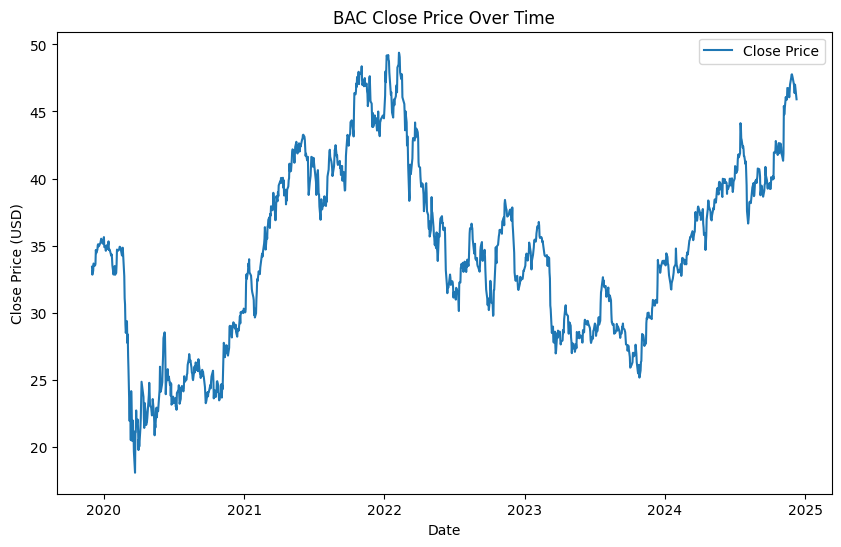

In [137]:
# Plot close price over time
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label="Close Price")
plt.title(f"{stock_ticker} Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

### 3.3 Analyze Trading Volume Spikes

This identifies and visualizes trading days with unusually high volumes (top 5%)

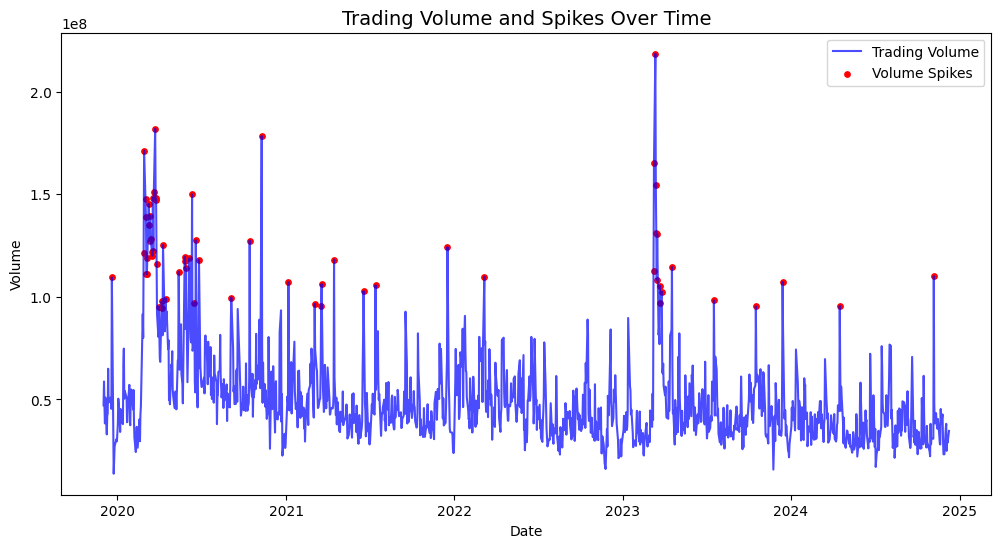

In [138]:
# Ensure proper datetime index for data
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

# Drop rows with missing values
data.dropna(inplace=True)

# Calculate the threshold for volume spikes (top 5%)
threshold = data['Volume'].quantile(0.95)

# Create a new column for volume spikes
data['Volume_Spike'] = data['Volume'] > threshold

# Plot trading volume with spikes highlighted
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Volume'], label='Trading Volume', color='blue', alpha=0.7)
plt.scatter(data.loc[data['Volume_Spike']].index, 
            data.loc[data['Volume_Spike'], 'Volume'], 
            color='red', label='Volume Spikes', s=15)
plt.title("Trading Volume and Spikes Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()

#### 3.4 Visualize Key Price Movements

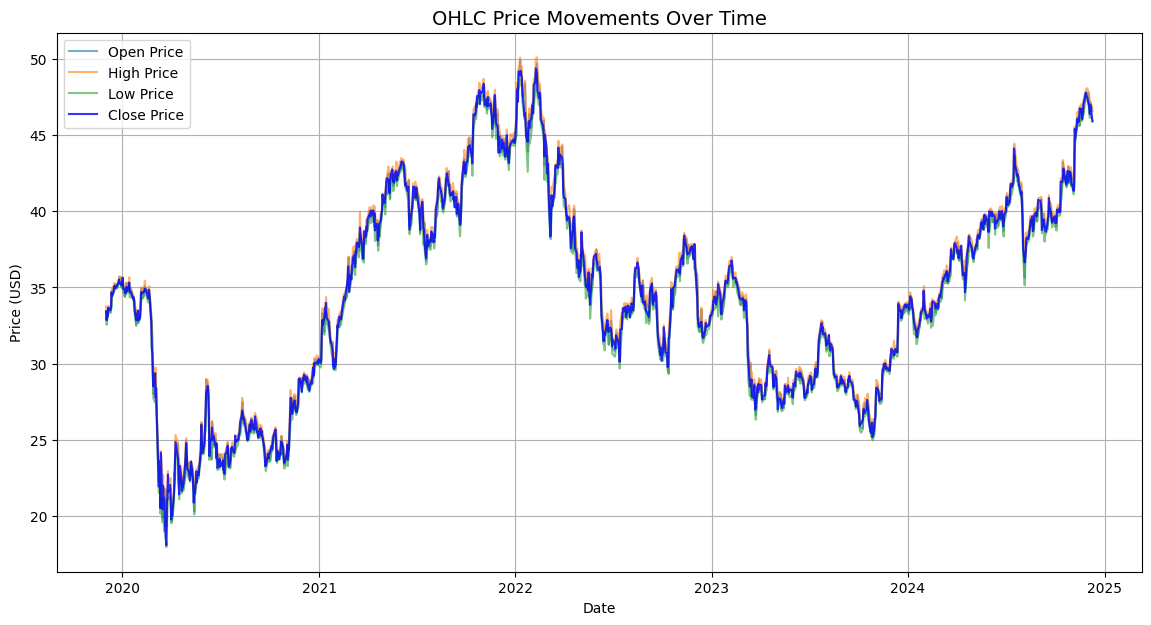

In [139]:
# Plot open, high, low, and close prices over time
plt.figure(figsize=(14, 7))
plt.plot(data['Open'], label='Open Price', alpha=0.6)
plt.plot(data['High'], label='High Price', alpha=0.6)
plt.plot(data['Low'], label='Low Price', alpha=0.6)
plt.plot(data['Close'], label='Close Price', color='blue', alpha=0.8)
plt.title("OHLC Price Movements Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()

#### 3.5 Identify Outliers in Close Prices

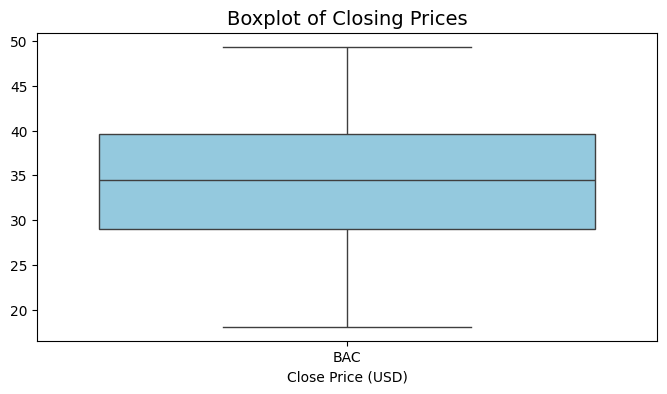

In [140]:
# Boxplot to check for outliers in the closing price
plt.figure(figsize=(8, 4))
sns.boxplot(data['Close'], color="skyblue")
plt.title("Boxplot of Closing Prices", fontsize=14)
plt.xlabel("Close Price (USD)")
plt.show()

#### 3.6 Distribution of Daily Returns

Evaluates risk and return patterns.

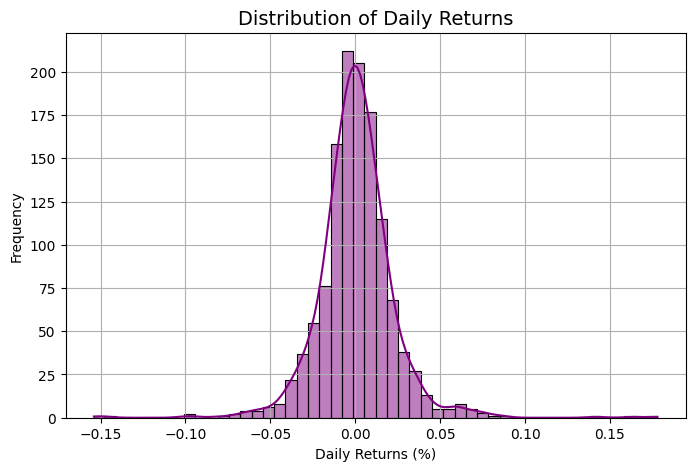

In [141]:
# Calculate daily returns
data['Daily_Returns'] = data['Close'].pct_change()

# Plot the distribution of daily returns
plt.figure(figsize=(8, 5))
sns.histplot(data['Daily_Returns'].dropna(), bins=50, kde=True, color="purple")
plt.title("Distribution of Daily Returns", fontsize=14)
plt.xlabel("Daily Returns (%)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

#### 3.7 Key Statistical Insights

Summarizes bullish vs. bearish days.

In [142]:
# Analyze percentage of days with positive vs. negative returns
positive_days = (data['Daily_Returns'] > 0).sum()
negative_days = (data['Daily_Returns'] <= 0).sum()
total_days = len(data['Daily_Returns'].dropna())

print(f"Percentage of Positive Days: {positive_days / total_days * 100:.2f}%")
print(f"Percentage of Negative Days: {negative_days / total_days * 100:.2f}%")

Percentage of Positive Days: 50.12%
Percentage of Negative Days: 49.88%


### Step 4: Feature Engineering (Add Technical Indicators)

In [143]:
# Function to calculate RSI
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(series, window=20):
    ma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper_bb = ma + (2 * std)
    lower_bb = ma - (2 * std)
    return upper_bb, lower_bb

# Function to calculate EMA (Exponential Moving Average)
def calculate_ema(series, span=10):
    return series.ewm(span=span, adjust=False).mean()


# Function to calculate MACD (Moving Average Convergence Divergence)
def calculate_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line


# Function to calculate On-Balance Volume (OBV)
def calculate_obv(df):
    obv = np.where(df['Close'] > df['Close'].shift(1), df['Volume'], 
                   np.where(df['Close'] < df['Close'].shift(1), -df['Volume'], 0))
    df['OBV'] = obv.cumsum()  # Cumulative sum of OBV changes
    return df


# Volatility-Based Features: ATR (Average True Range): Measures market volatility
def calculate_atr(df, window=14):
    high_low = df['High'] - df['Low']
    high_close = abs(df['High'] - df['Close'].shift(1))
    low_close = abs(df['Low'] - df['Close'].shift(1))
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    atr = true_range.rolling(window=window).mean()
    df['ATR'] = atr
    return df

# Historical Volatility: Standard deviation of returns over a period
def calculate_historical_volatility(df, window=14):
    df['Historical_Volatility'] = df['Close'].pct_change().rolling(window=window).std() * np.sqrt(252)  # Annualized
    return df



# Function to calculate CCI (Commodity Channel Index)
def calculate_cci(df, window=20):
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = typical_price.rolling(window=window).mean()
    mad = typical_price.rolling(window=window).apply(lambda x: np.fabs(x - x.mean()).mean(), raw=True)
    cci = (typical_price - sma_tp) / (0.015 * mad)
    return cci


# Function to calculate Stochastic Oscillator
def calculate_stochastic_oscillator(df, k_period=14, d_period=3):
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()
    df['%K'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))
    df['%D'] = df['%K'].rolling(window=d_period).mean()
    return df



# Add features to the dataset
def add_technical_indicators(df):
    #df['SMA_20'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_50'] = calculate_ema(df['Close'], span=10)
    df['RSI'] = calculate_rsi(df['Close'])
    df['BB_upper'], df['BB_lower'] = calculate_bollinger_bands(df['Close'])
    df['Price_Change_%'] = df['Close'].pct_change() * 100
    df['MACD'], df['MACD_signal'] = calculate_macd(df['Close'])
    df = calculate_stochastic_oscillator(df)
    df = calculate_obv(df)  
    df = calculate_atr(df)  
    df = calculate_historical_volatility(df)  # Add Historical Volatility
    df['CCI'] = calculate_cci(df)
    df['Volume'] = df['Volume']  # Retain Volume for trend analysis
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    return df.dropna()

# Add indicators to the data
data = add_technical_indicators(data)


In [144]:
# Add RSI lags
for lag in range(1, 4):
    data[f'RSI_lag_{lag}'] = data['RSI'].shift(lag)

# Display the last few rows of the dataset
data.tail()

Price,Adj Close,Close,High,Low,Open,Volume,Volume_Spike,Daily_Returns,SMA_50,EMA_50,...,%K,%D,OBV,ATR,Historical_Volatility,CCI,Target,RSI_lag_1,RSI_lag_2,RSI_lag_3
Ticker,BAC,BAC,BAC,BAC,BAC,BAC,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-03,46.560997,46.820000,47.480000,46.650002,47.369999,38123800,False,-0.004677,43.1376,46.917584,...,48.780461,61.234637,-288706400,0.737857,0.133076,54.746865,0,61.320750,75.211829,81.120334
2024-12-04,46.113483,46.369999,46.779999,46.130001,46.689999,24941300,False,-0.009611,43.2760,46.818023,...,30.487769,45.663940,-313647700,0.740714,0.141216,-4.518085,1,61.320750,61.320750,75.211829
2024-12-05,46.740002,47.000000,47.240002,46.500000,46.560001,31572100,False,0.013586,43.4310,46.851110,...,56.097538,45.121923,-282075600,0.772143,0.151240,37.128801,0,55.341880,61.320750,61.320750
2024-12-06,46.750000,46.750000,47.060001,46.400002,47.060001,28931700,False,-0.005319,43.5756,46.832726,...,38.425946,41.670418,-311007300,0.732143,0.132631,9.075027,0,60.416655,55.341880,61.320750
2024-12-09,45.910000,45.910000,46.750000,45.900002,46.560001,34660900,False,-0.017968,43.7058,46.664958,...,0.458639,31.660707,-345668200,0.755000,0.153126,-71.950749,0,50.000000,60.416655,55.341880


#### 4.2 Line Graphs of Engineered Features

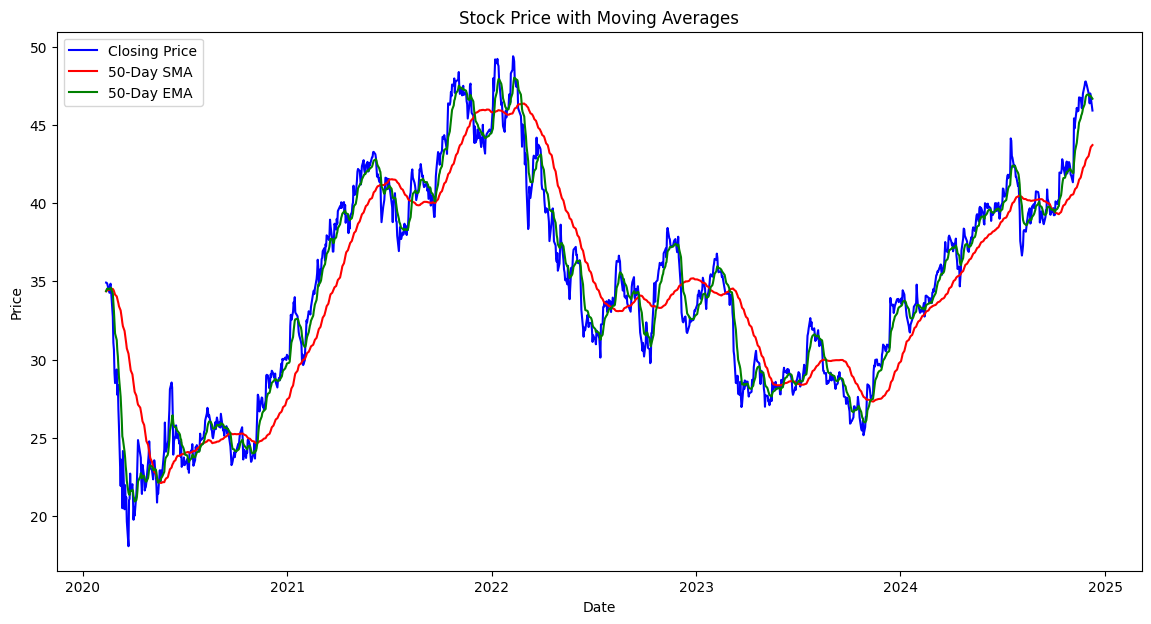

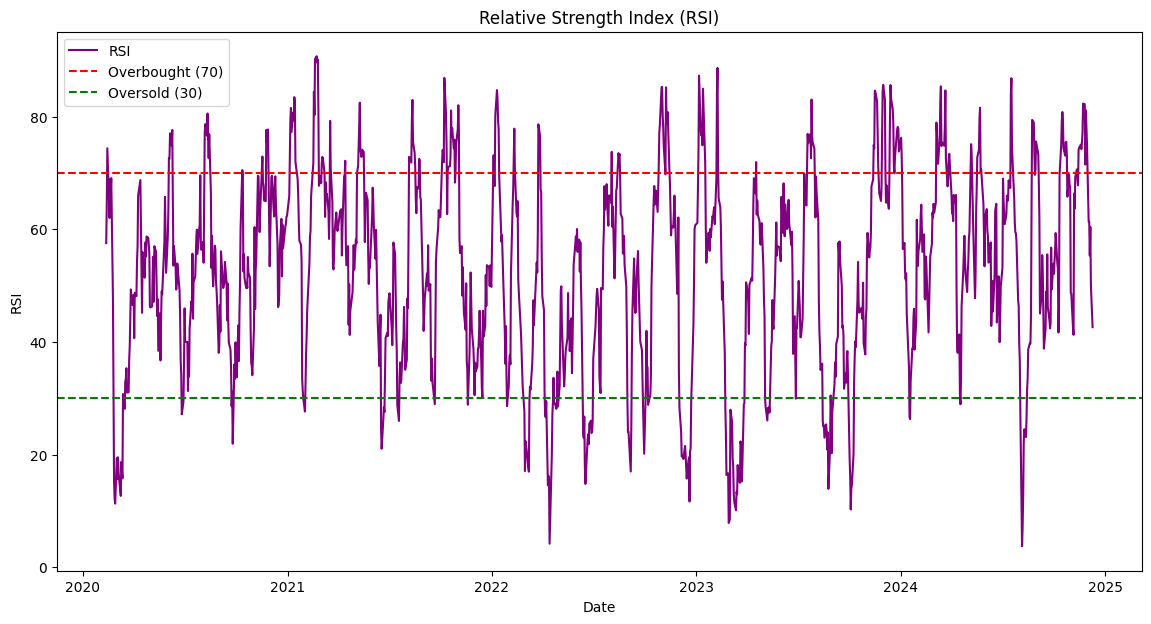

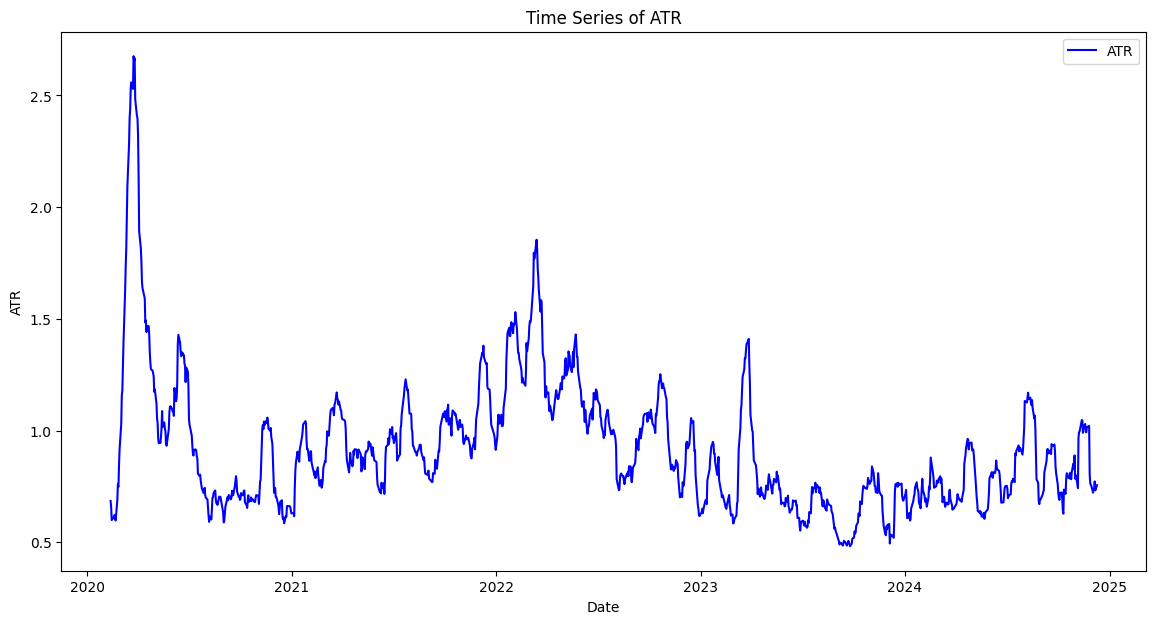

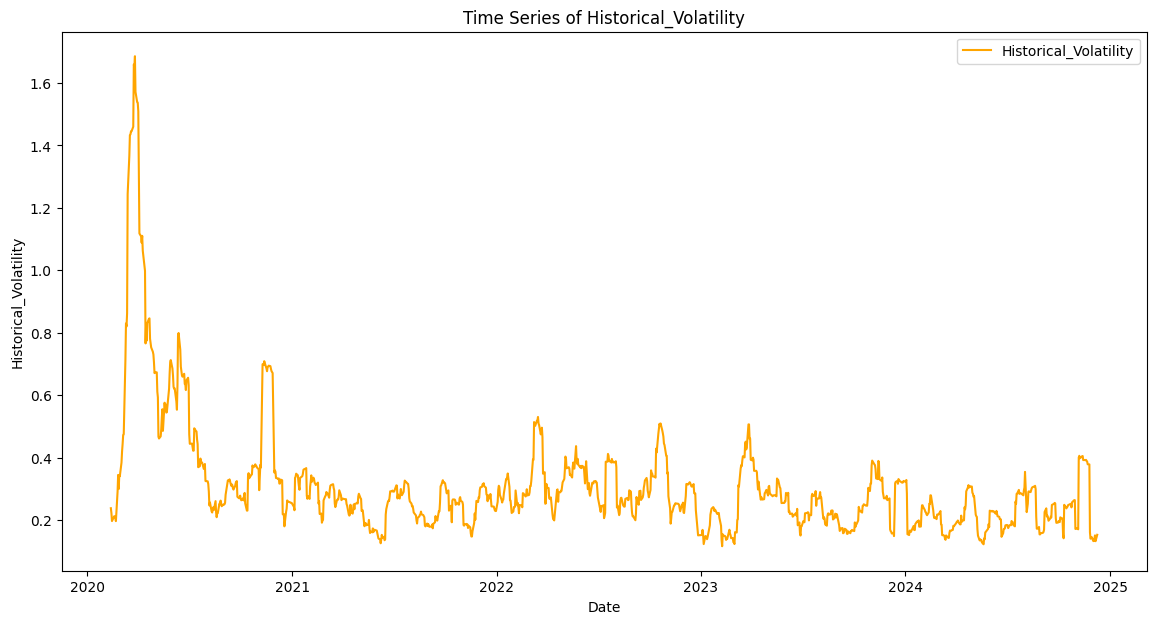

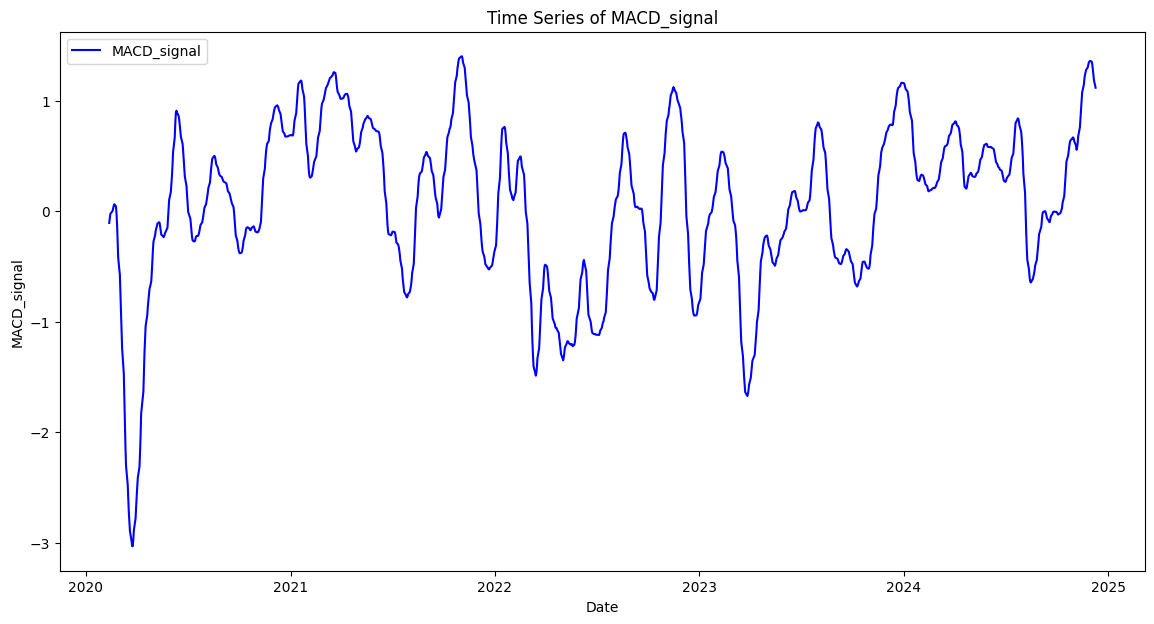

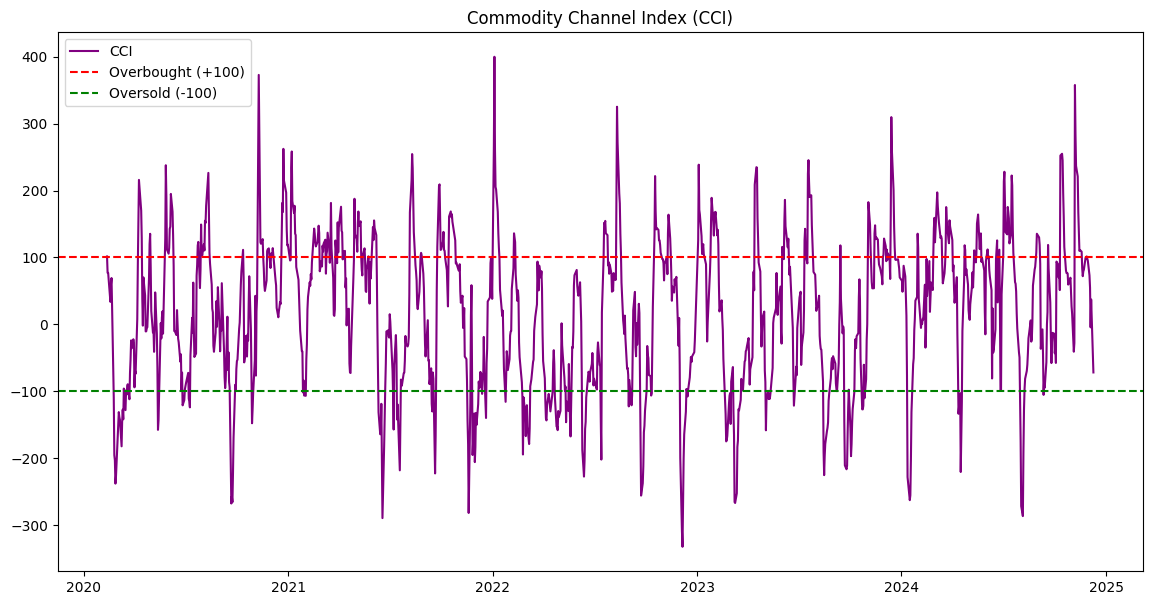

In [145]:
# Plot Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Closing Price', color='blue')
#plt.plot(data.index, data['SMA_20'], label='20-Day SMA', color='orange')
plt.plot(data.index, data['SMA_50'], label='50-Day SMA', color='red')
plt.plot(data.index, data['EMA_50'], label='50-Day EMA', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price with Moving Averages')
plt.legend()
plt.show()

# Plot RSI
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('Relative Strength Index (RSI)')
plt.legend()
plt.show()


# Plot ATR
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['ATR'], label='ATR', color='blue')
plt.xlabel('Date')
plt.ylabel('ATR')
plt.title('Time Series of ATR')
plt.legend()
plt.show()


# Plot Historical_Volatility
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Historical_Volatility'], label='Historical_Volatility', color='orange')
plt.xlabel('Date')
plt.ylabel('Historical_Volatility')
plt.title('Time Series of Historical_Volatility')
plt.legend()
plt.show()


# Plot MACD_signal
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['MACD_signal'], label='MACD_signal', color='blue')
plt.xlabel('Date')
plt.ylabel('MACD_signal')
plt.title('Time Series of MACD_signal')
plt.legend()
plt.show()



#### Plot CCI
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['CCI'], label="CCI", color="purple")
plt.axhline(100, color="red", linestyle="--", label="Overbought (+100)")
plt.axhline(-100, color="green", linestyle="--", label="Oversold (-100)")
plt.title("Commodity Channel Index (CCI)")
plt.legend()
plt.show()

#### 4.3 Correlation Heatmap
This heatmap shows correlations between features.

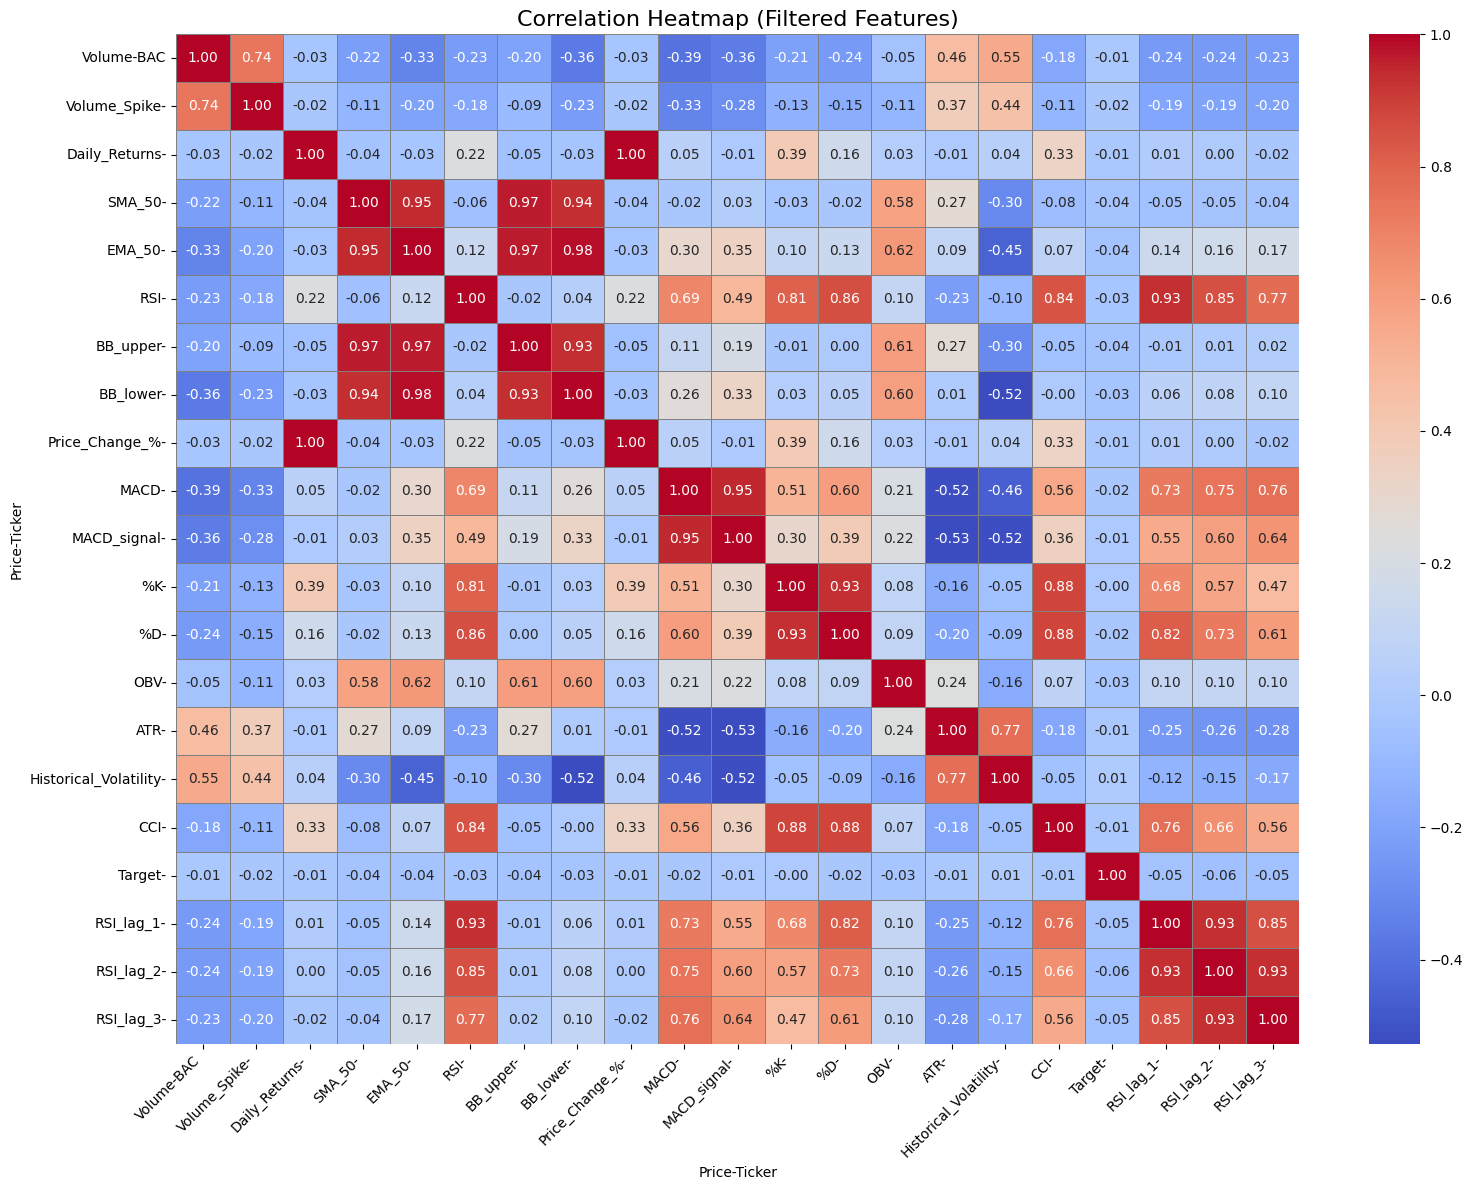

In [146]:
# Drop the unwanted features
filtered_data = data.drop(columns=['Adj Close', 'Close', 'High', 'Low', 'Open'])

# Compute correlation matrix
corr_matrix = filtered_data.corr()

# Plot the heatmap with adjustments
plt.figure(figsize=(16, 12))  # Increased figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
            annot_kws={"size": 10}, linewidths=0.5, linecolor='gray')  # Smaller annotations, cell borders

plt.title('Correlation Heatmap (Filtered Features)', fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha='right')  # Rotate x labels
plt.yticks(fontsize=10, rotation=0)  # Rotate y labels
plt.tight_layout()  # Adjust layout for better fit
plt.show()

### Highly Correlated Features to Consider Dropping
- Volume-META vs. Volume Spike: Keep only one. Volume Spike may better capture volatility.
- SMA_20, SMA_50, EMA_50: These are highly correlated with each other. Keep only one representative feature (EMA_50) to avoid multicollinearity.
- BB Upper vs. BB Lower vs. SMA_20/SMA_50/EMA_50: Drop BB Upper and BB Lower as they are derived from the moving averages. Since they don't add unique information, drop both BB Upper and BB Lower.
- OBV (On-Balance Volume): Highly correlated with SMA_20, SMA_50, and EMA_50. Drop OBV.
- MACD & MACD Signal are highly correlated, so MACD Signal has been dropped.
- %K, & %D are highly correlated with RSI, so both have been dropped

### Final Selected Features
- Volume Spike: Indicates trading activity spikes, relevant for predictions.
- EMA_50: Represents moving average trends, a good predictor of market behavior.
- RSI (Relative Strength Index): Low-to-moderate correlation but a critical momentum indicator.
- MACD: Essential for identifying trend reversals.
- Historical Volatility: Useful for gauging market uncertainty, moderate correlation (0.58) with Volume-META.
- Price _Change_%: 
- ATR:


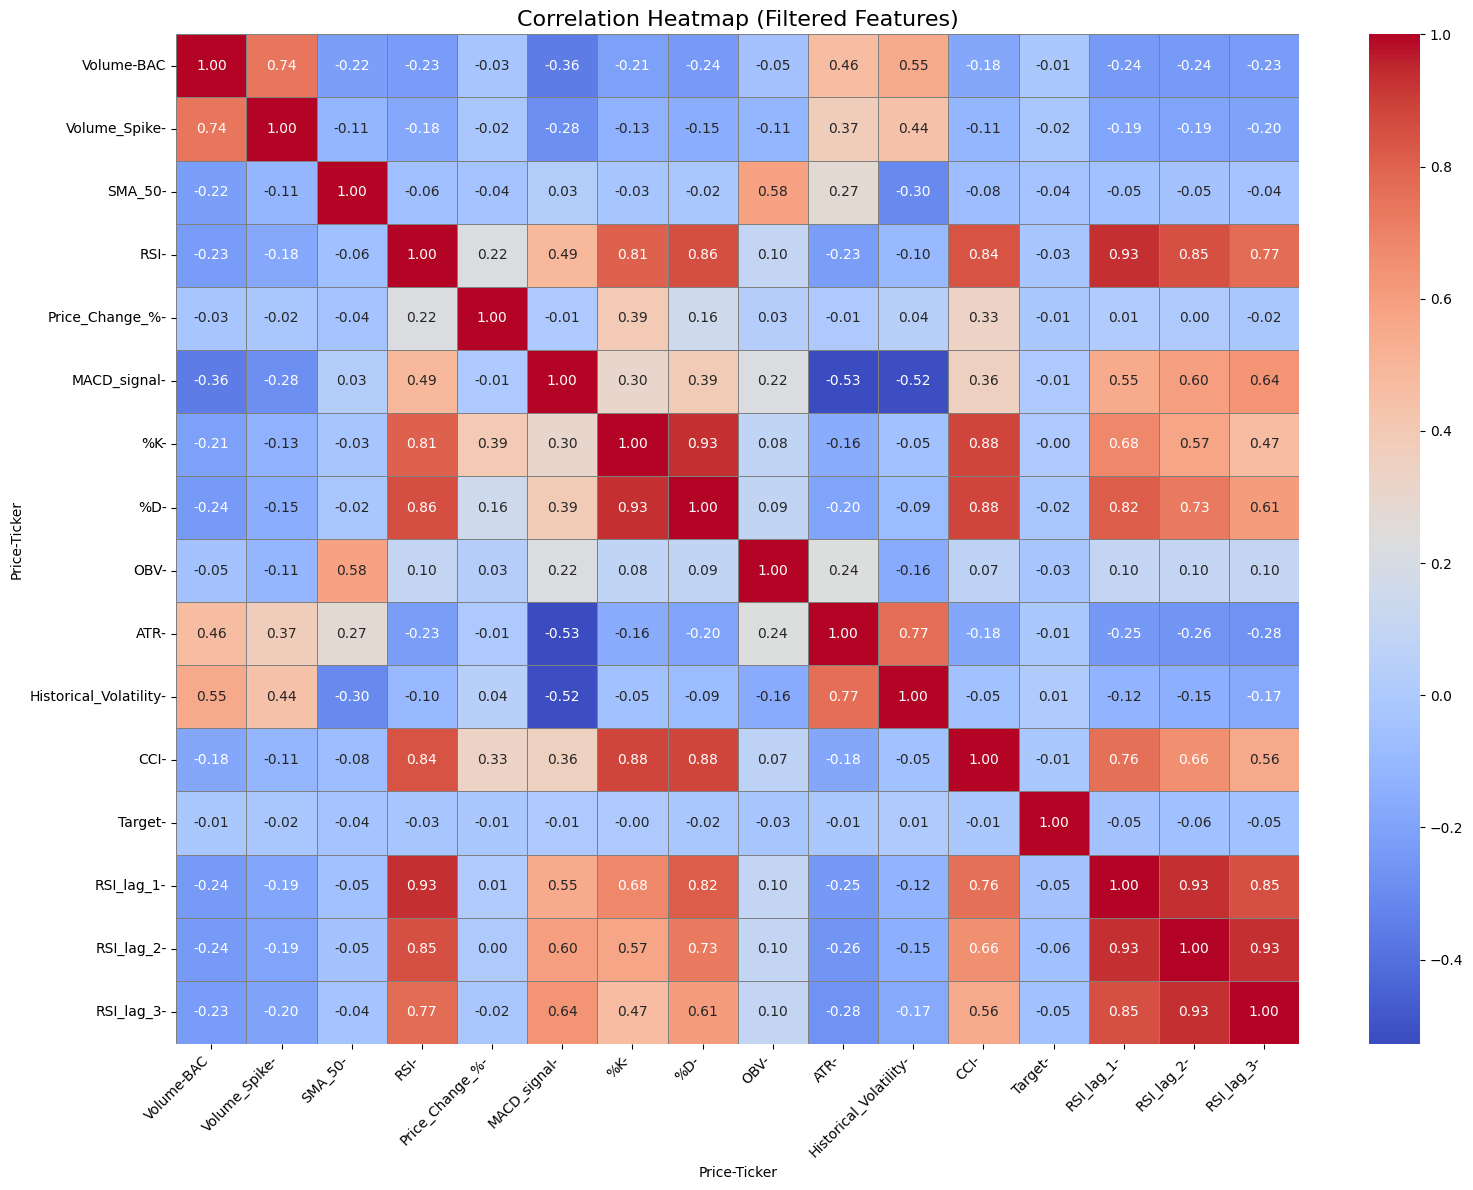

In [147]:
# Drop the Highly Correlated
filtered_data = data.drop(columns=['Adj Close', 'Close', 'High', 'Low', 'Open', 'EMA_50', 'BB_upper', 'BB_lower', 'MACD', 'Daily_Returns'])

# Compute correlation matrix
corr_matrix = filtered_data.corr()

# Plot the heatmap with adjustments
plt.figure(figsize=(16, 12))  # Increased figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
            annot_kws={"size": 10}, linewidths=0.5, linecolor='gray')  # Smaller annotations, cell borders
plt.title('Correlation Heatmap (Filtered Features)', fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha='right')  # Rotate x labels
plt.yticks(fontsize=10, rotation=0)  # Rotate y labels
plt.tight_layout()  # Adjust layout for better fit
plt.show()

### Step 5: Split Data into Training and Testing Sets

In [148]:
scaler = StandardScaler()
features = data.drop(columns=['Target', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'EMA_50', 'BB_upper', 'Daily_Returns'])
scaled_features = scaler.fit_transform(features)
data[features.columns] = scaled_features

# Define features and target
X = data.drop(columns=['Target', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'EMA_50', 'BB_upper', 'Daily_Returns'])
y = data['Target']


# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

# Print sorted feature importances
print("Feature importances:")
for idx in sorted_indices:
    print(f"{X.columns[idx]}: {importances[idx] :.2f}")

Feature importances:
('OBV', ''): 0.07
('RSI_lag_1', ''): 0.07
('Historical_Volatility', ''): 0.07
('RSI_lag_2', ''): 0.06
('Price_Change_%', ''): 0.06
('Volume', 'BAC'): 0.06
('ATR', ''): 0.06
('RSI_lag_3', ''): 0.06
('BB_lower', ''): 0.06
('RSI', ''): 0.06
('%D', ''): 0.06
('CCI', ''): 0.06
('SMA_50', ''): 0.06
('MACD_signal', ''): 0.06
('%K', ''): 0.06
('MACD', ''): 0.06
('Volume_Spike', ''): 0.00


In [149]:
# Fill NaN values with the mean of each column
X = X.fillna(X.mean())

# Split the data (Train-test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Store feature names before scaling
feature_names = X_train.columns

# Normalize the Features (Feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Base model for RFE
base_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform Recursive Feature Elimination (RFE)
rfe = RFE(estimator=base_model, n_features_to_select=14)  # Adjust the number of features
rfe.fit(X_train_scaled, y_train)

# Get the mask of selected features
rfe_support = rfe.support_

# Retrieve the selected feature names using the original feature names
selected_features = feature_names[rfe_support]
print(f"Selected Features: {selected_features}")

# Transform the dataset using only the selected features
X_train_selected = pd.DataFrame(X_train_scaled, columns=feature_names)[selected_features]
X_test_selected = pd.DataFrame(X_test_scaled, columns=feature_names)[selected_features]

Selected Features: MultiIndex([(               'Volume', 'BAC'),
            (               'SMA_50',    ''),
            (                  'RSI',    ''),
            (             'BB_lower',    ''),
            (       'Price_Change_%',    ''),
            (                 'MACD',    ''),
            (                   '%D',    ''),
            (                  'OBV',    ''),
            (                  'ATR',    ''),
            ('Historical_Volatility',    ''),
            (                  'CCI',    ''),
            (            'RSI_lag_1',    ''),
            (            'RSI_lag_2',    ''),
            (            'RSI_lag_3',    '')],
           names=['Price', 'Ticker'])


### 6. Train and Compare Models

In [150]:
# Step 6: Train and Compare Models
# Logistic Regression
print("\n--- Logistic Regression ---")
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Cross-validation for Logistic Regression
lr_cv_scores = cross_val_score(estimator=lr_model, X=X_train, y=y_train, cv=5, scoring='accuracy')
print(f"Logistic Regression CV Scores: {lr_cv_scores}")
print(f"Logistic Regression Mean CV Score: {lr_cv_scores.mean():.2f}")

# Performance Metrics
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_preds))

# Decision Tree Classifier
print("\n--- Decision Tree ---")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

# Cross-validation for Decision Tree
dt_cv_scores = cross_val_score(estimator=dt_model, X=X_train, y=y_train, cv=5, scoring='accuracy')
print(f"Decision Tree CV Scores: {dt_cv_scores}")
print(f"Decision Tree Mean CV Score: {dt_cv_scores.mean():.2f}")

# Performance Metrics
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_preds))

# Random Forest Classifier
print("\n--- Random Forest ---")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(estimator=rf_model, X=X_train, y=y_train, cv=5, scoring='accuracy')
print(f"Random Forest CV Scores: {rf_cv_scores}")
print(f"Random Forest Mean CV Score: {rf_cv_scores.mean():.2f}")

# Performance Metrics
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))

# Compare Model Accuracy
print("\n--- Model Accuracy Comparison ---")
models = ["Logistic Regression", "Decision Tree", "Random Forest"]
accuracies = [
    accuracy_score(y_test, lr_preds),
    accuracy_score(y_test, dt_preds),
    accuracy_score(y_test, rf_preds)
]

for model, acc in zip(models, accuracies):
    print(f"{model}: {acc:.2f}")

# Output Best Performing Model
best_model_index = np.argmax(accuracies)
print(f"\nBest Performing Model: {models[best_model_index]} with Accuracy: {accuracies[best_model_index]:.2f}")



--- Logistic Regression ---
Logistic Regression CV Scores: [0.48205128 0.54358974 0.53608247 0.56701031 0.45876289]
Logistic Regression Mean CV Score: 0.52
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.49      0.50       122
           1       0.50      0.50      0.50       121

    accuracy                           0.50       243
   macro avg       0.50      0.50      0.50       243
weighted avg       0.50      0.50      0.50       243


--- Decision Tree ---
Decision Tree CV Scores: [0.57435897 0.54871795 0.48969072 0.54639175 0.48969072]
Decision Tree Mean CV Score: 0.53
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.52      0.51       122
           1       0.51      0.50      0.51       121

    accuracy                           0.51       243
   macro avg       0.51      0.51      0.51       243
weighted avg       0.51  

### 6.2 Visualize Results

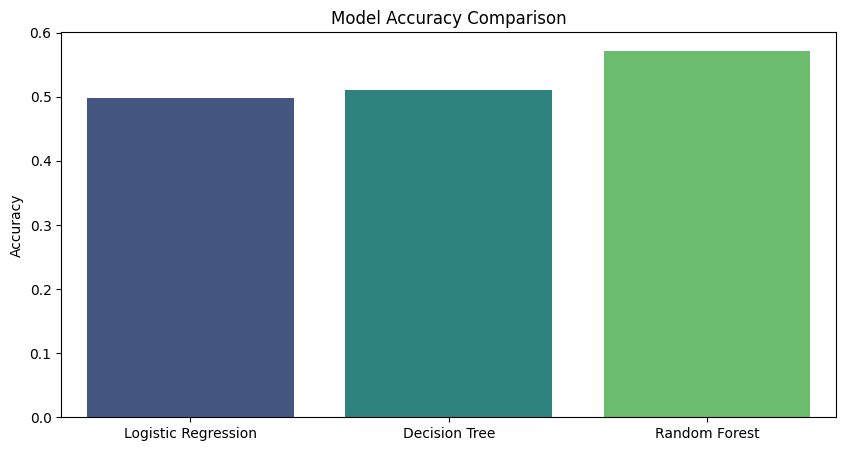

In [151]:
# Compare model performance
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracies = [
    accuracy_score(y_test, lr_preds),
    accuracy_score(y_test, dt_preds),
    accuracy_score(y_test, rf_preds)
]

# Plot comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=accuracies, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

### 6.3  Model Training with GridSearchCV for Decision tree

In [152]:
# Define parameter grid for RandomForestClassifier tuning
param_grid = {
    'n_estimators': [50, 100, 150],          # Number of trees in the forest
    'max_depth': [3, 5, 7, None],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],           # Minimum samples required at a leaf node
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',  # Use F1-score to account for precision-recall balance
    cv=5,          # 5-fold cross-validation
    verbose=1,
    n_jobs=-1      # Use all available cores
)

# Fit the model to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Retrieve the optimized model
optimized_rf_model = grid_search.best_estimator_

# Evaluate the optimized model on the test set
optimized_rf_preds = optimized_rf_model.predict(X_test)
print("Optimized Random Forest Performance:\n", classification_report(y_test, optimized_rf_preds))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Optimized Random Forest Performance:
               precision    recall  f1-score   support

           0       0.55      0.57      0.56       122
           1       0.55      0.53      0.54       121

    accuracy                           0.55       243
   macro avg       0.55      0.55      0.55       243
weighted avg       0.55      0.55      0.55       243



### 6.4 Feature Importance Visualization

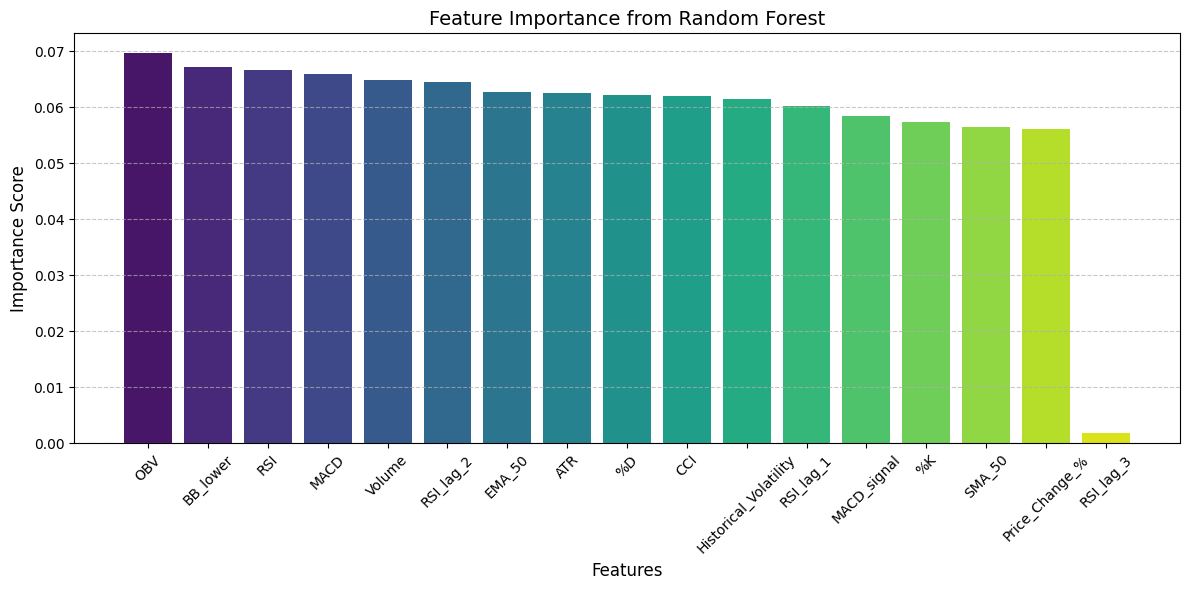

In [153]:
# Generate feature importance data
importances = rf_model.feature_importances_  
features = ['Volume', 'RSI_lag_3', 'RSI_lag_1', 'RSI_lag_2', 'SMA_50', 'RSI', 'Price_Change_%', 'MACD_signal', '%K', '%D', 'OBV', 'ATR', 'Historical_Volatility', 'CCI', 'EMA_50', 'BB_lower', 'MACD']
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Create a colormap
colors = sns.color_palette("viridis", len(importance_df))

# Plot with custom colors
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color=colors)
plt.title('Feature Importance from Random Forest', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add a light grid for clarity
plt.tight_layout()
plt.show()

### 7. Generate Predictions

Accuracy: 0.57
Precision: 0.58
Recall: 0.53
F1 Score: 0.55


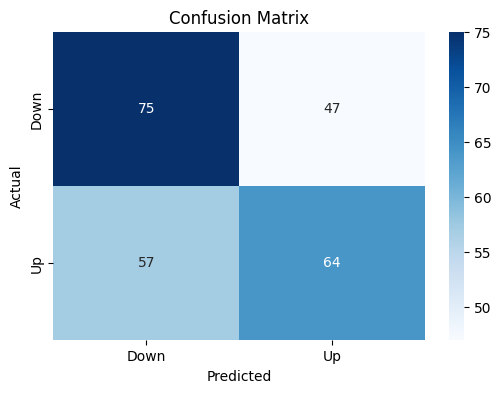

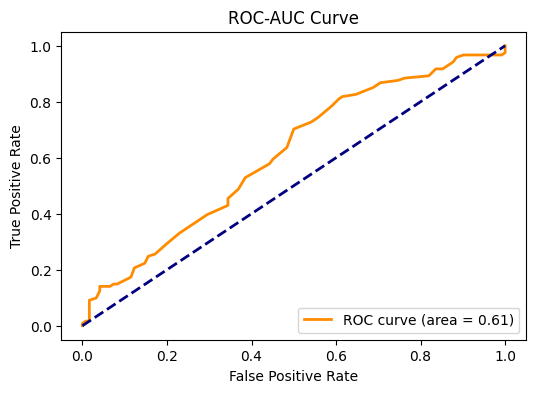

In [154]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Generate predictions
y_pred = rf_model.predict(X_test)  # Predicted labels
y_prob = rf_model.predict_proba(X_test)  # Predicted probabilities

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])  
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [156]:
# Extract the latest data (last row)
latest_data = X.iloc[-1:]  # Ensure it's shaped like our feature set

# Make a prediction for the next day
next_day_prediction = dt_model.predict(latest_data)

# Interpret the result
if next_day_prediction[0] == 1:
    print("The model predicts the stock price will go UP tomorrow.")
else:
    print("The model predicts the stock price will go DOWN tomorrow.")

The model predicts the stock price will go DOWN tomorrow.


Note:ROC Curve is not constant when I change some dete range it changes 